In [1]:
%reset
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np

import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import model_MultiShapeCirclesTranslation as model

torch.set_default_tensor_type(torch.DoubleTensor)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
nb_pts1 = 10
nb_pts2 = 7
dim = 2

o1 = torch.tensor([0.,0.])
o2 = torch.tensor([10.,0.])
origin = [o1,o2]
r1 = 2
r2 = 1
radius = [r1, r2]
nb_pts = [nb_pts1, nb_pts2]
source = mm.multipleCircles(origin, radius, nb_pts)

origin_target = [[10., 0.], [0, 5.]]
target = mm.multipleCircles(origin_target, radius, nb_pts)


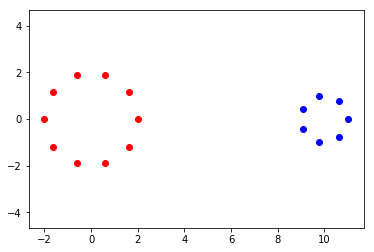

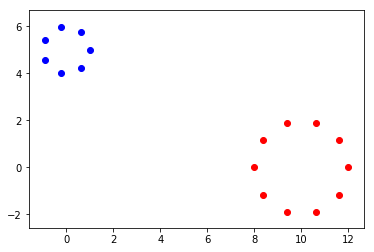

In [3]:
plt.figure()
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

plt.figure()
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [4]:
# Defining the deformation modules
sigma1 = 20
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
trans1 = dm.deformationmodules.GlobalTranslation(manifold1, sigma1)
trans1.fill_controls_zero()
#trans1 = dm.deformationmodules.Translations(manifold1, sigma1)
mod1 = dm.deformationmodules.CompoundModule([trans1])

sigma2 = 20
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1))
trans2 = dm.deformationmodules.GlobalTranslation(manifold2, sigma2)
trans2.fill_controls_zero()
#trans2 = dm.deformationmodules.Translations(manifold2, sigma2)
mod2 = dm.deformationmodules.CompoundModule([trans2])

module_list = [mod1, mod2]
sigma_bg = 1.
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

In [5]:
constr_Id = dm.constraints.Identity()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [6]:
# compound
#gd0_list = [[source[0].view(-1), source[1].view(-1)], source[1].view(-1), [source[0].view(-1), source[1].view(-1)], source[1].view(-1)]
#mom0_list = [*[[torch.rand(x.shape) for x in man.unroll_gd()] for man in modules.manifold.manifold_list[:-1]], [[torch.rand(x.shape) for x in man.unroll_gd()] for man in modules.manifold.manifold_list[-1]]]

#H.module.manifold.fill_gd([gd0_list[0], gd0_list[1], [gd0_list[2][0], gd0_list[2][1]]])
#H.module.manifold.fill_cotan([mom0_list[0], mom0_list[1], [mom0_list[2][0], mom0_list[2][1]]])
#H.geodesic_controls()

In [7]:
# set parameters
reg_param = 10**-3 

gd0_tensor = torch.cat([source[0], source[1], source[0], source[1]],0).requires_grad_().view(-1)
mom0_tensor = torch.zeros(gd0_tensor.shape).requires_grad_().view(-1)
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
EnergyFunctional = model.EnergyFunctional(modules, H, constr_Id, source, target, dim, reg_param)

# do registration
X = [gd0_tensor, mom0_tensor]
X = model.gradientdescent(EnergyFunctional, X)

cost: 0.0 attach: 91.47953711285248
 iter : 0  ,total energy: 91.47953711285248
cost: 0.0 attach: 91.47953711285248
cost: 0.00123061908512 attach: 85.6045009785737
c 0
 iter : 0  ,total energy: 85.60573159765882
cost: 0.00123061908512 attach: 85.6045009785737
cost: 0.00528955985124 attach: 80.54297355690856
c 0
 iter : 1  ,total energy: 80.5482631167598
cost: 0.00528955985124 attach: 80.54297355690856
cost: 0.0107811914335 attach: 77.36375765985807
c 0
 iter : 2  ,total energy: 77.37453885129156
cost: 0.0107811914335 attach: 77.36375765985807
cost: 0.0171275552531 attach: 75.07898653306945
c 0
 iter : 3  ,total energy: 75.09611408832258
cost: 0.0171275552531 attach: 75.07898653306945
cost: 0.0249614943888 attach: 73.0096967910214
c 0
 iter : 4  ,total energy: 73.03465828541016
cost: 0.0249614943888 attach: 73.0096967910214
cost: 0.0356815611216 attach: 70.72537929109394
c 0
 iter : 5  ,total energy: 70.76106085221551
cost: 0.0356815611216 attach: 70.72537929109394
cost: 0.0511174544206

cost: 0.186888294083 attach: 63.007356832099866
cost: 0.187017569942 attach: 63.00694794164464
c 3
 iter : 46  ,total energy: 63.19396551158625
cost: 0.187017569942 attach: 63.00694794164464
cost: 0.18753288552 attach: 63.00634366233486
c 4
 iter : 47  ,total energy: 63.193876547854615
cost: 0.18753288552 attach: 63.00634366233486
cost: 0.187390740585 attach: 63.00761751977625
Condition 0: tensor(1, dtype=torch.uint8)
Condition 1, 2, 3: tensor(1, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: False
c 5
 iter : 48  ,total energy: 63.19500826036086
 iter : 49  ,total energy: 63.19500826036086


In [8]:
X = model.gradientdescent(EnergyFunctional, X)

cost: 0.18753288552 attach: 63.00634366233486
 iter : 0  ,total energy: 63.193876547854615
cost: 0.18753288552 attach: 63.00634366233486
cost: 0.187520337187 attach: 63.006252631349795
Condition 0: tensor(0, dtype=torch.uint8)
Condition 1, 2, 3: tensor(1, dtype=torch.uint8) tensor(1, dtype=torch.uint8) tensor(1, dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: False
c 1
 iter : 0  ,total energy: 63.193772968537
cost: 0.187520337187 attach: 63.006252631349795
cost: 0.187521106342 attach: 63.00618428972721
Condition 0: tensor(0, dtype=torch.uint8)
Condition 1, 2, 3: tensor(1, dtype=torch.uint8) tensor(1, dtype=torch.uint8) tensor(1, dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: False
c 2
 iter : 1  ,total energy: 63.193705396069525
cost: 0.187521106342 attach: 63.00618428972721
cost: 0.187549281974 attach: 63.00612190793666
Condition 0: tensor(0, dtype=torch.uint8)
Condition 1, 2, 3: tensor(1, dtype=torch.uint8) tensor(1, dtype=torch.u

In [12]:
optimized_mom = EnergyFunctional.tensor2list(X[1])

In [9]:
H.module.manifold.fill_gd(EnergyFunctional.tensor2list(X[0]))
H.module.manifold.fill_cotan(EnergyFunctional.tensor2list(X[1]))

states, controls = dm.shooting.shoot_euler(H, it=10)


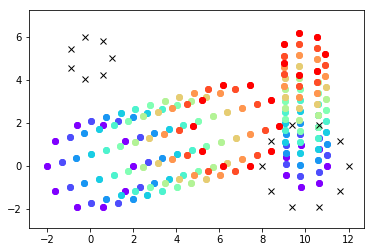

In [10]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

plt.figure()
for s,c in zip(states, colors):
    plt.scatter(s.gd[0][0].view(-1,2)[:, 0].detach().numpy(), s.gd[0][0].view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s.gd[1][0].view(-1,2)[:, 0].detach().numpy(), s.gd[1][0].view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s.gd[2][0][0].view(-1,2)[:, 0].detach().numpy(), s.gd[2][0][0].view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s.gd[2][1][0].view(-1,2)[:, 0].detach().numpy(), s.gd[2][1][0].view(-1,2)[:, 1].detach().numpy(), c=c)
plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

    
plt.axis('equal')
plt.show()

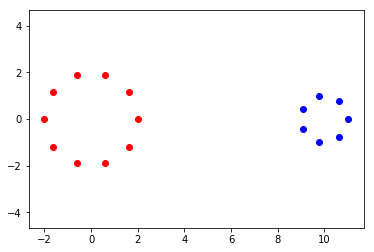

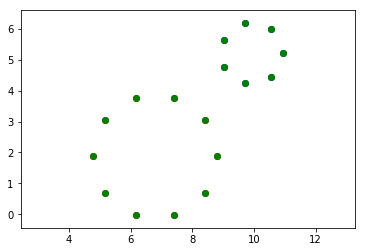

In [13]:
plt.figure()
gd0_list = [source[0], source[1]]
plt.scatter(gd0_list[0].view(-1,2)[:, 0].detach().numpy(), gd0_list[0].view(-1,2)[:, 1].detach().numpy(), c='red')
plt.scatter(gd0_list[1].view(-1,2)[:, 0].detach().numpy(), gd0_list[1].view(-1,2)[:, 1].detach().numpy(), c='blue')
plt.axis('equal')


gd_moved = EnergyFunctional.h.module.manifold.gd

plt.figure()
plt.scatter(gd_moved[0][0].view(-1,2)[:, 0].detach().numpy(), gd_moved[0][0].view(-1,2)[:, 1].detach().numpy(), c='red')
plt.scatter(gd_moved[1][0].view(-1,2)[:, 0].detach().numpy(), gd_moved[1][0].view(-1,2)[:, 1].detach().numpy(), c='blue')
plt.scatter(gd_moved[2][0][0].view(-1,2)[:, 0].detach().numpy(), gd_moved[2][0][0].view(-1,2)[:, 1].detach().numpy(), c='green')

plt.scatter(gd_moved[2][1][0].view(-1,2)[:, 0].detach().numpy(), gd_moved[2][1][0].view(-1,2)[:, 1].detach().numpy(), c='green')

plt.axis('equal')

plt.show()

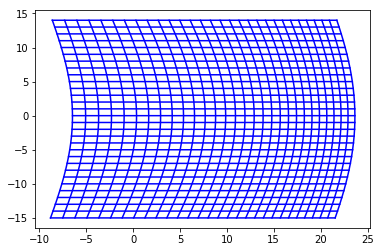

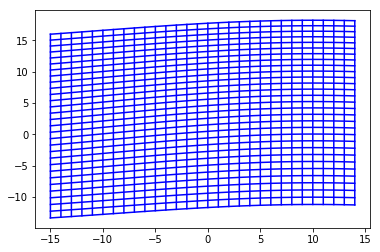

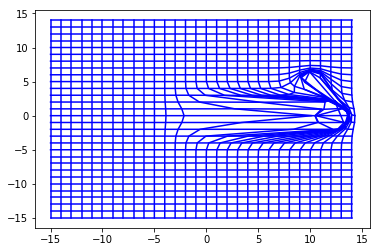

In [31]:
# Visualization of grid deformation for each submodule
nx, ny = 30, 30
sx, sy = 30, 30
x, y = torch.meshgrid([torch.arange(0, nx), torch.arange(0, ny)])
x = sx*(x.type(torch.DoubleTensor)/nx - 0.5)
y = sy*(y.type(torch.DoubleTensor)/ny - 0.5)

gridpoints = dm.usefulfunctions.grid2vec(x, y).type(torch.DoubleTensor)


phi = mm.largeDeformation(modules, states, controls, gridpoints)
x1, y1 = dm.usefulfunctions.vec2grid(phi[0], nx, ny)
x2, y2 = dm.usefulfunctions.vec2grid(phi[1], nx, ny)
x3, y3 = dm.usefulfunctions.vec2grid(phi[2], nx, ny)



mm.plot_grid( x1.detach().numpy(), y1.detach().numpy(), color = 'blue')
mm.plot_grid(x2.detach().numpy(), y2.detach().numpy(), color = 'blue')
mm.plot_grid( x3.detach().numpy(), y3.detach().numpy(), color = 'blue')
plt.show()
